In [31]:
import matplotlib.pyplot as plt
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np

In [32]:
libraries_path = "/home/neel/Sem_8/AE6102/Project/temp/"
spice_library = SpiceLibrary(libraries_path)

In [33]:
list(spice_library.models)

['nmos', 'pmos', 'nmos_F', 'pmos_F', 'nmos_S', 'pmos_S']

In [58]:
circuit = Circuit('NMOS Transistor')
circuit.include(spice_library['nmos'])

# Define the DC supply voltage value
Vdd = 2.2

# Instanciate circuit elements
circuit.V('gate_1', 'gatenode_1', circuit.gnd, 0.8)
circuit.V('gate_2', 'gatenode_2', circuit.gnd, 0.8)
circuit.R(1, 'drain_1', 'vdd', "20k")
circuit.R(2, 'drain_2', 'vdd', "20k")
circuit.V(1, 'vdd', circuit.gnd, u_V(Vdd))
circuit.I(1,'source', 0,'106u')
# M <name> <drain node> <gate node> <source node> <bulk/substrate node>
circuit.MOSFET(1, 'drain_1', 'gatenode_1', 'source', circuit.gnd, model='nmos', l = "1u", w="1u")
circuit.MOSFET(2, 'drain_2', 'gatenode_2', 'source', circuit.gnd, model='nmos', l = "1u", w="1u")

for r in (circuit.R1, circuit.R2):
    r.minus.add_current_probe(circuit)
print(circuit)

.title NMOS Transistor
.include /home/neel/Sem_8/AE6102/Project/temp/130nm_bulk.lib
Vgate_1 gatenode_1 0 0.8
Vgate_2 gatenode_2 0 0.8
R1 drain_1 R1_minus 20k
R2 drain_2 R2_minus 20k
V1 vdd 0 2.2V
I1 source 0 106u
M1 drain_1 gatenode_1 source 0 nmos l=1u w=1u
M2 drain_2 gatenode_2 source 0 nmos l=1u w=1u
VR1_minus vdd R1_minus 0
VR2_minus vdd R2_minus 0



In [65]:
async def ckt_gen(circuit,params):
    # print(os.getpid())
    for i in params:
        i.resistance = params[i]
    print(circuit)
    simulator = circuit.simulator(
        temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    return (float(analysis.nodes['2']))


async def run(index, no_of_threads):
    circuit = Circuit("Sims")
    circuit.R('1', 1, 2, "1k")
    circuit.R('2', 2, 0, "1k")
    circuit.V('1', 1, 0, 3.3)
    params = {}
    resistors = []
    e = list(circuit.element_names)
    for i in e:
        if(i[0] == 'R'):
            resistors.append(circuit[i])
    tasks = []
    for i in range(no_of_threads):
        params[resistors[0]] = str(1+index+i)+"k"
        params[resistors[1]] = "1k"
        print(params)
        tasks.append(asyncio.create_task(
            ckt_gen(circuit = circuit,params = params)))
    ans = await asyncio.gather(*tasks)
    return (ans)


def child(index, no_of_threads):
    ans = asyncio.run(run(index, no_of_threads))
    return (ans)

In [64]:
class monte_carlo_sims():
    def __init__(self, circuit, no_of_simulations=2, tol=10,path="/home/neel/Sem_8/AE6102/Project/temp/"):
        self.circuit = circuit
        self.no_of_simulations = no_of_simulations
        self.resistors = []
        self.mosfet_nmos = []
        self.mosfet_pmos = []
        self.capacitors = []
        self.libraries_nmos = []
        self.libraries_pmos = []
        self.cases = [] 
        self.result = np.array([])
        self.path_to_library(path)
        self.segregate()
        self.create_sims(tol)   
    

    def path_to_library(self,path):
        for i in list(SpiceLibrary(path).models):
            if('pmos' in  i):
                self.libraries_pmos.append(i)
            else:
                self.libraries_nmos.append(i)

    def segregate(self):
        for i in list(self.circuit.element_names):
            if(i[0] == 'R'):
                self.resistors.append(self.circuit[i])
            elif(i[0] == 'M' and (circuit[i].model[0] == 'n')):
                self.mosfet_nmos.append(self.circuit[i])
            elif(i[0] == 'M' and (circuit[i].model[0] == 'p')):
                self.mosfet_pmos.append(self.circuit[i])
            elif(i[0] == 'C'):
                self.capacitors.append(self.circuit[i])
    
    def create_sims(self, tol):
        for i in range(self.no_of_simulations):
            tasks = {}
            model_nmos = self.libraries_nmos[np.random.randint(0,len(self.libraries_nmos))]
            model_pmos = self.libraries_pmos[np.random.randint(0,len(self.libraries_pmos))]
            for j in self.mosfet_nmos:
                length = float(j.length[:-1]) + (np.random.rand()*tol/100)
                width = float(j.width[:-1]) + (np.random.rand()*tol/100)
                tasks[j] = [model_nmos, length, width]
            for j in self.mosfet_pmos:
                length = float(j.length[:-1]) + (np.random.rand()*tol/100)
                width = float(j.width[:-1]) + (np.random.rand()*tol/100)
                tasks[j] = [model_pmos, length, width]   
            self.cases.append(tasks)


    def solve(self):
        no_of_cpu = (os. cpu_count())
        pool = mp.Pool()
        threads_per_core = int(self.no_of_simulations/no_of_cpu)
        leftover_threads = self.no_of_simulations - (threads_per_core*no_of_cpu)

        if (self.no_of_simulations < 12):
            a = [pool.apply_async(child, args=(i, 1)) for i in range(no_sims)]
            pool.close()
            pool.join()
        else:
            index = np.arange(0, self.no_of_simulations, threads_per_core)
            a = [pool.apply_async(child, args=(index[i], threads_per_core))
                for i in range(no_of_cpu)]
            pool.close()
            pool.join()
            if (leftover_threads != 0):
                b = child(threads_per_core*no_of_cpu, leftover_threads)
                self.result = np.append(result, b)
        for i in a:
            self.result = np.append(self.result, i.get())
        self.result = self.result.flatten()
        for i in self.result:
            print(i)
            plt.plot(i, '*')
        plt.savefig('sims_result_process_asyncio.png')

    def plot(self):
        for i in self.result:
            print(i)
            plt.plot(i, '*')
        plt.savefig('sims_result_process_asyncio.png')  
monte_carlo_sims(circuit=circuit, no_of_simulations=2, tol=10)

In [8]:
circuit.R1.resistance="20k"
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.operating_point()
voltage_diff = np.array(analysis.nodes['drain_1']) - np.array(analysis.nodes['drain_2'])
current_m1 = np.array(analysis.branches["vr1_minus"])
current_m2 = np.array(analysis.branches["vr2_minus"])
print(voltage_diff)

[2.22044605e-16]


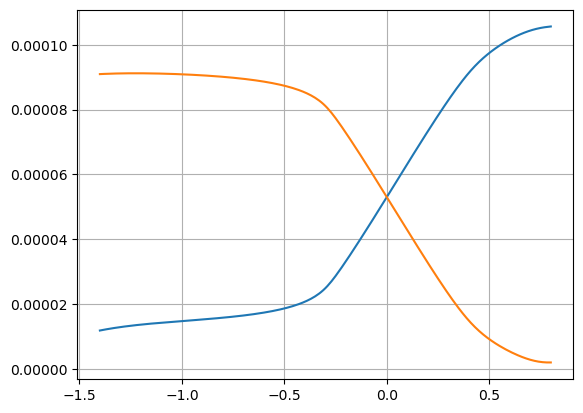

In [9]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(Vgate_2=slice(0,Vdd,0.01))
voltage_diff = np.array(analysis.nodes['gatenode_1']) - np.array(analysis.nodes['gatenode_2'])
current_m1 = np.array(analysis.branches["vr1_minus"])
current_m2 = np.array(analysis.branches["vr2_minus"])
plt.plot(voltage_diff, current_m1)
plt.plot(voltage_diff, current_m2)
plt.grid()
plt.show()

In [67]:
def ckt_gen(circuit, args):
    for i in args:
        i.model = args[i][0]
        i.length = args[i][1]
        i.width = args[i][2]
    print(circuit)
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.operating_point()
    voltage_diff = np.array(analysis.nodes['drain_1']) - np.array(analysis.nodes['drain_2'])
    current_m1 = np.array(analysis.branches["vr1_minus"])
    current_m2 = np.array(analysis.branches["vr2_minus"])
    print(voltage_diff)

circuit = Circuit('NMOS Transistor')
circuit.include(spice_library['nmos'])
Vdd = 2.2
circuit.V('gate_1', 'gatenode_1', circuit.gnd, 0.8)
circuit.V('gate_2', 'gatenode_2', circuit.gnd, 0.8)
circuit.R(1, 'drain_1', 'vdd', "20k")
circuit.R(2, 'drain_2', 'vdd', "20k")
circuit.V(1, 'vdd', circuit.gnd, u_V(Vdd))
circuit.I(1,'source', 0,'106u')
circuit.MOSFET(1, 'drain_1', 'gatenode_1', 'source', circuit.gnd, model='nmos', l = "1u", w="1u")
circuit.MOSFET(2, 'drain_2', 'gatenode_2', 'source', circuit.gnd, model='nmos', l = "1u", w="1u")

for r in (circuit.R1, circuit.R2):
    r.minus.add_current_probe(circuit)

tasks = {}
mosfets = []
e = list(circuit.element_names)
for i in e:
    if(i[0] == 'M'):
        mosfets.append(circuit[i])
for i in mosfets:
    tasks[i] = ['nmos', 1 + np.random.rand(), 1 + np.random.rand()]
ckt_gen(circuit,tasks)

.title NMOS Transistor
.include /home/neel/Sem_8/AE6102/Project/temp/130nm_bulk.lib
Vgate_1 gatenode_1 0 0.8
Vgate_2 gatenode_2 0 0.8
R1 drain_1 R1_minus 20k
R2 drain_2 R2_minus 20k
V1 vdd 0 2.2V
I1 source 0 106u
M1 drain_1 gatenode_1 source 0 nmos l=1.4309441973512975 w=1.7848914775685398
M2 drain_2 gatenode_2 source 0 nmos l=1.4201495216872277 w=1.6491205867213996
VR1_minus vdd R1_minus 0
VR2_minus vdd R2_minus 0

[-0.00311173]
